In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed


# **Utils**

In [ ]:
def video2frame(filepath, resize=(224,224)):

    cap = cv2.VideoCapture(filepath)
    # num of frames
    len_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # print(len_frames)
    len_frames = int(len_frames)
    frames = []
    try:
        for i in range(len_frames):
            _, frame = cap.read()
            frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224, 224, 3))
            frames.append(frame)
    except:
        print("error: ", filepath, len_frames, i)
    finally:
        frames = np.array(frames)
        cap.release()

    flows = calc_optical_flow(frames)

    result = np.zeros((len(flows), 224, 224, 5))
    result[..., :3] = frames
    result[..., 3:] = flows

    frames = uniform_sampling(result, 20)
    return frames


def frame_difference(frames):
    num_frames = len(frames)
    out = []
    for i in range(num_frames - 1):
        out.append(cv2.subtract(frames[i + 1], frames[i]))

    return np.array(out)


def uniform_sampling(frames, target_frames=10):
    num_frames = len(frames)
    skip_frames = num_frames//target_frames
    out = []

    for i in range(target_frames):
        out.append(frames[i * skip_frames])

    return np.array(out)


def flow_to_color(video):
    rgb_flows = []

    cap = cv2.VideoCapture(video)

    ret, first_frame = cap.read()

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros_like(first_frame)

    # Sets image saturation to maximum
    mask[..., 1] = 255

    while (cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                           None,
                                           0.5, 3, 15, 3, 5, 1.2, 0)

        # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Sets image hue according to the optical flow direction
        mask[..., 0] = angle * 180 / np.pi / 2

        # Sets image value according to the optical flow magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        # Converts HSV to RGB (BGR) color representation
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        resized_rgb = cv2.resize(rgb, (224, 224), interpolation=cv2.INTER_AREA)
        rgb_flows.append(resized_rgb)

        prev_gray = gray

        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    # rgb_flows.append(np.zeros((224, 224, 3)))
    # cv2.destroyAllWindows()

    return np.array(rgb_flows)



def Save2Npy(file_dir, save_dir):
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name + '.npy')
        # Load and preprocess video
        data = video2frame(video_path, resize=(224, 224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

def Save2Npy2(file_dir, save_dir):
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name + '.npy')
        # Load and preprocess video
        data = flow_to_color(video_path)
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

def calc_optical_flow(frames):
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in frames]

    dense_flow = []

    for i in range(1, len(gray_frames)):
        prev_frame = gray_frames[i-1]
        cur_frame = gray_frames[i]

        flow = cv2.calcOpticalFlowFarneback(prev_frame, cur_frame, None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)

        dense_flow.append(flow)
    # Padding the last frame as empty array
    dense_flow.append(np.zeros((224, 224, 2)))

    return np.array(dense_flow, dtype=np.float32)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = "drive/MyDrive/dataset3"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  800
file train/nonfight: 800
file val/fight:  200
file val/nonfight:  200


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames, flow = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0

        frame = data[:, :, :, :3]
        flow = data[:, :, :, 3:]

        return frame, flow

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset3/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (20, 224, 224, 3)
Label: [1. 0.]


In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=3)
  return embed.embed_file('./animation.gif')


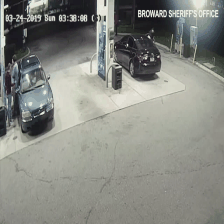

In [ ]:
to_gif(frames)

In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(2,), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)

In [ ]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
Shape: (8, 20, 224, 224, 3)
Label: (8, 2

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy, loss, and AUC values
    plt.figure(figsize=(21, 5))  # Adjust the figsize to accommodate more plots

    # Plot training & validation accuracy values
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation AUC values
    plt.subplot(1, 3, 3)
    plt.plot(history['auc_2'])
    plt.plot(history['val_auc_2'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


# **LR 1e-4**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_6 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_8[0][0]']             
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)  (None, 20, 7, 7, 256)        2123468   ['time_distributed_6[0][0]']  
                                                          8                                       
                                                                                            

In [ ]:
epochs = 20
lr = 1e-4

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 129s 512ms/step - loss: 0.6076 - accuracy: 0.6825 - auc_2: 0.7466 - val_loss: 1.2682 - val_accuracy: 0.5000 - val_auc_2: 0.5224
Epoch 2/20
200/200 [==============================] - 99s 497ms/step - loss: 0.4249 - accuracy: 0.8219 - auc_2: 0.8893 - val_loss: 0.7746 - val_accuracy: 0.7225 - val_auc_2: 0.7733
Epoch 3/20
200/200 [==============================] - 99s 497ms/step - loss: 0.2528 - accuracy: 0.9038 - auc_2: 0.9599 - val_loss: 0.6353 - val_accuracy: 0.8000 - val_auc_2: 0.8730
Epoch 4/20
200/200 [==============================] - 99s 495ms/step - loss: 0.1599 - accuracy: 0.9450 - auc_2: 0.9828 - val_loss: 0.8239 - val_accuracy: 0.7725 - val_auc_2: 0.8434
Epoch 5/20
200/200 [==============================] - 100s 501ms/step - loss: 0.1261 - accuracy: 0.9581 - auc_2: 0.9889 - val_loss: 0.6277 - val_accuracy: 0.8000 - val_auc_2: 0.8556
Epoch 6/20
200/200 [==============================] - 99s 496ms/step - loss: 0.0842 - accurac

In [ ]:
result_metric = model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 148ms/step - loss: 0.6277 - accuracy: 0.8000 - auc_2: 0.8556


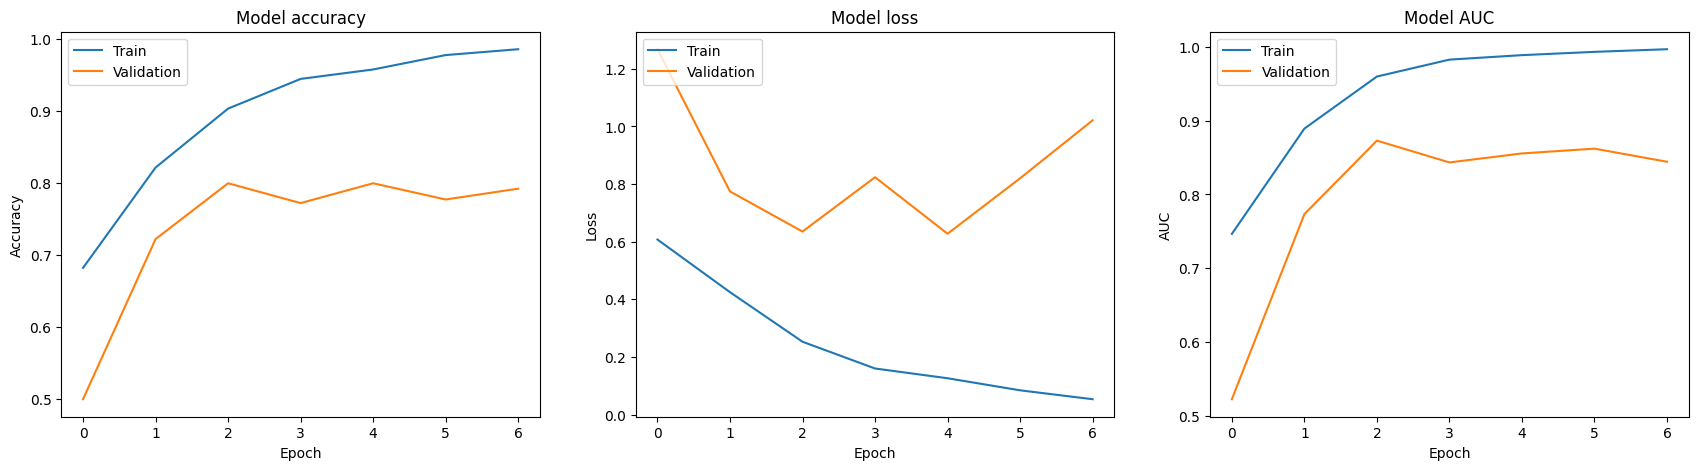

In [ ]:
plot_history(results.history)

# **Ganti Learning rate**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_8 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_11[0][0]']            
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_12 (ConvLSTM2D  (None, 20, 7, 7, 256)        2123468   ['time_distributed_8[0][0]']  
 )                                                        8                                       
                                                                                           

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 130s 513ms/step - loss: 0.6907 - accuracy: 0.5938 - auc_3: 0.6336 - val_loss: 0.6927 - val_accuracy: 0.5525 - val_auc_3: 0.5387
Epoch 2/20
200/200 [==============================] - 99s 497ms/step - loss: 0.6763 - accuracy: 0.6556 - auc_3: 0.7212 - val_loss: 0.6641 - val_accuracy: 0.6750 - val_auc_3: 0.7502
Epoch 3/20
200/200 [==============================] - 99s 497ms/step - loss: 0.6287 - accuracy: 0.6994 - auc_3: 0.7759 - val_loss: 0.5813 - val_accuracy: 0.7525 - val_auc_3: 0.8038
Epoch 4/20
200/200 [==============================] - 99s 496ms/step - loss: 0.5456 - accuracy: 0.7406 - auc_3: 0.8279 - val_loss: 0.5248 - val_accuracy: 0.7725 - val_auc_3: 0.8197
Epoch 5/20
200/200 [==============================] - 100s 502ms/step - loss: 0.4666 - accuracy: 0.7962 - auc_3: 0.8694 - val_loss: 0.5136 - val_accuracy: 0.7650 - val_auc_3: 0.8253
Epoch 6/20
200/200 [==============================] - 99s 495ms/step - loss: 0.3969 - accurac

In [ ]:
result_metric = model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 148ms/step - loss: 0.5136 - accuracy: 0.7650 - auc_3: 0.8253


In [ ]:
def plot_history2(history):
    # Define the metrics you want to plot
    metrics = list(history.keys())[:3]

    # Determine the number of plots needed
    num_plots = len(metrics)

    # Adjust the figsize to accommodate more plots
    plt.figure(figsize=(7 * num_plots, 5))

    for i, metric in enumerate(metrics):
        # Plot training & validation metric values
        plt.subplot(1, num_plots, i + 1)
        plt.plot(history[metric])
        plt.plot(history[f'val_{metric}'])
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

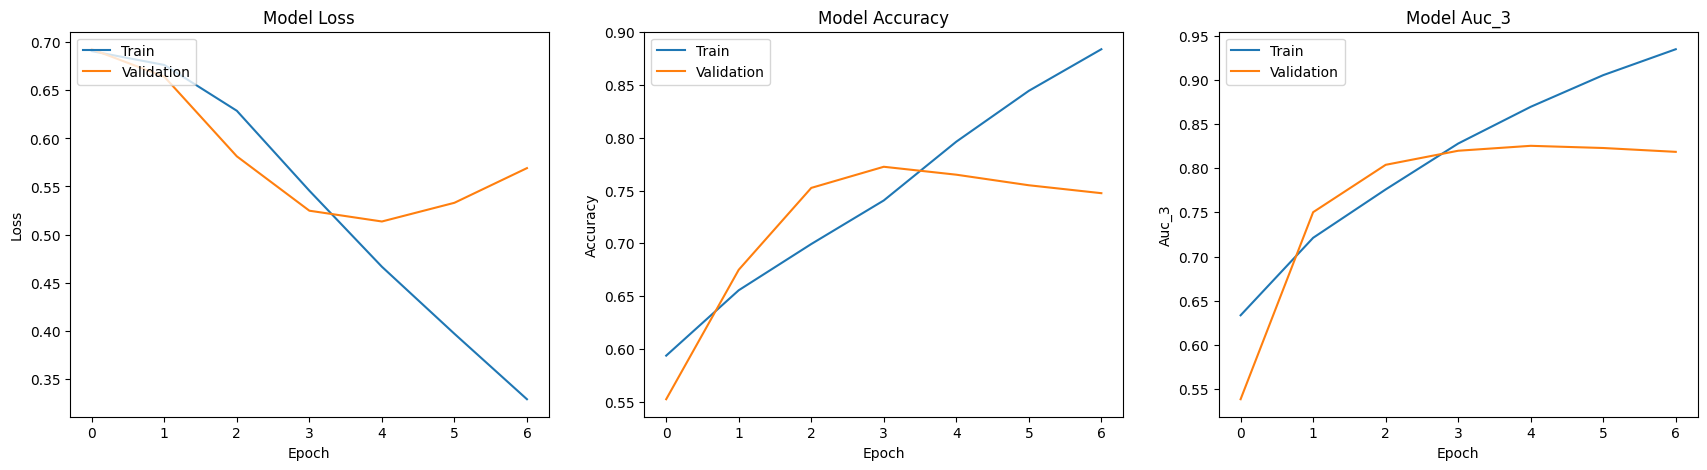

In [ ]:
plot_history2(results.history)

# **Coba hitung optical flow**

In [ ]:
DIR2 = "drive/MyDrive/dataset"

In [ ]:
os.listdir(DIR)

['train', 'val']

In [ ]:
class FrameGeneratorFlow:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            video_frames_flow = self.flow_to_color(video_frames)
            label = self.class_ids_for_name[name]
            label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))
            yield video_frames_flow, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0

        # frame = data[:, :, :, :3]
        # flow = data[:, :, :, 3:]
        # return frame, flow
        return data

    def flow_to_color(self, video):
        rgb_flows = []

        first_frame = video[0]

        prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

        # Creates an image filled with zero intensities with the same dimensions as the frame
        mask = np.zeros_like(first_frame)

        # Sets image saturation to maximum
        mask[..., 1] = 255

        for i in range(1, len(video)):
            frame = video[i]


            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Calculates dense optical flow by Farneback method
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None,
                                                0.5, 3, 15, 3, 5, 1.2, 0)

            # Computes the magnitude and angle of the 2D vectors
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Sets image hue according to the optical flow direction
            mask[..., 0] = angle * 180 / np.pi / 2

            # Sets image value according to the optical flow magnitude (normalized)
            mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

            # Converts HSV to RGB (BGR) color representation
            rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

            resized_rgb = cv2.resize(rgb, (224, 224), interpolation=cv2.INTER_AREA)
            rgb_flows.append(resized_rgb)

            prev_gray = gray


        return np.array(rgb_flows)

In [ ]:
train_file = Path(DIR2).joinpath("train").with_suffix('')
test_file = Path(DIR2).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset/train')

In [ ]:
fg = FrameGeneratorFlow(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (20, 224, 224, 3)
Label: [1. 0.]


In [ ]:
def to_gif(images, path):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave(path, converted_images, fps=3)
  return embed.embed_file(path)


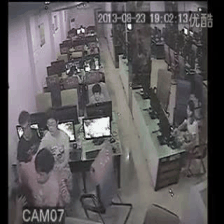

In [ ]:
to_gif(frames, './animation.gif')


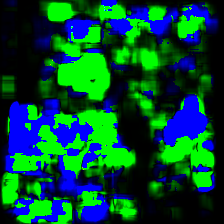

In [ ]:
to_gif(frames_flow, './animation_flow.gif')

In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(2,), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGeneratorFlow(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGeneratorFlow(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)
test_ds = test_ds.shuffle(buffer_size=1000).batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(5):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor(
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]], shape=(8, 2), dtype=int16)
Shape: (8, 20, 224, 224, 3)
Label: (8, 2)


In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_opt = tf.keras.Model(inputs=video_input, outputs=dense_4)

model_opt.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_12 (TimeD  (None, 20, 7, 7, 2048)       2358771   ['input_19[0][0]']            
 istributed)                                              2                                       
                                                                                                  
 conv_lstm2d_20 (ConvLSTM2D  (None, 20, 7, 7, 256)        2123468   ['time_distributed_12[0][0]'] 
 )                                                        8                                       
                                                                                           

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_opt.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
results_opt = model_opt.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 911s 3s/step - loss: 0.6923 - accuracy: 0.5481 - auc_7: 0.5577 - val_loss: 0.6897 - val_accuracy: 0.6825 - val_auc_7: 0.6932
Epoch 2/20
200/200 [==============================] - 99s 496ms/step - loss: 0.6893 - accuracy: 0.6019 - auc_7: 0.6221 - val_loss: 0.6832 - val_accuracy: 0.6875 - val_auc_7: 0.7156
Epoch 3/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6827 - accuracy: 0.6200 - auc_7: 0.6489 - val_loss: 0.6699 - val_accuracy: 0.6975 - val_auc_7: 0.7339
Epoch 4/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6696 - accuracy: 0.6369 - auc_7: 0.6725 - val_loss: 0.6469 - val_accuracy: 0.7050 - val_auc_7: 0.7516
Epoch 5/20
200/200 [==============================] - 100s 500ms/step - loss: 0.6474 - accuracy: 0.6644 - auc_7: 0.7055 - val_loss: 0.6153 - val_accuracy: 0.7150 - val_auc_7: 0.7693
Epoch 6/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6144 - accuracy: 

In [ ]:
result_metric_opt = model_opt.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 148ms/step - loss: 0.5077 - accuracy: 0.7450 - auc_7: 0.8371


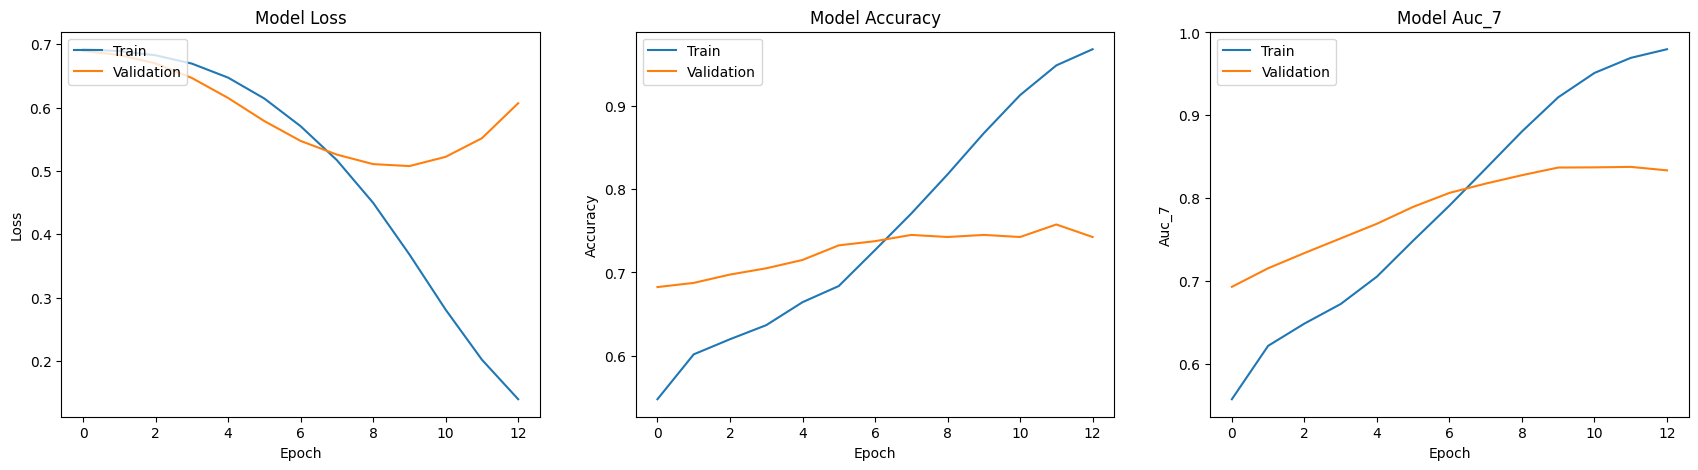

In [ ]:
plot_history2(results_opt.history)